# Identificação

**Assunto:** Modelagem

**Tutor:** Manoel Veríssimo dos Santos Neto e Matheus Patusco

## 1- Objetivos de Aprendizagem
Neste notebook, iremos:
1. Recuperar o dataset processado em CSV.
2. Comparar múltiplos algoritmos de machine learning.
3. Armazenar e versionar no MLflow o modelo com melhor desempenho e menor custo computacional.

### 1.1- Bibliotecas Necessárias
    

In [25]:
# Manipulação e visualização de dados
import pandas as pd
import seaborn as sns
import time

# Bibliotecas para aprendizado de máquina
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score

# Inicialização do Dagshub com integração MLflow
import dagshub
dagshub.init(repo_owner='ahmiura', repo_name='modelagem-exe1-regressao', mlflow=True)

# MLflow para gerenciamento de experimentos
import mlflow

mlflow.set_experiment("Experimento de Regressão - Tutoria Modelagem 1")


# Supressão de avisos
import warnings
warnings.filterwarnings("ignore")

Initialized MLflow to track repo "ahmiura/modelagem-exe1-regressao"

Repository ahmiura/modelagem-exe1-regressao initialized!

2025/11/02 17:06:59 INFO mlflow.tracking.fluent: Experiment with name 'Experimento de Regressão - Tutoria Modelagem 1' does not exist. Creating a new experiment.


## 2- Recuperando o Dataset do MLflow

In [26]:
# link https://www.kaggle.com/datasets/mirichoi0218/insurance

# Especificar o caminho do artefato no MLflow
artifact_path = "./dados/insurance.csv"

# Carregar o dataset processado
dados = pd.read_csv(artifact_path)
print("Informacoes do dataframe: ", dados.shape)
dados.head()

Informacoes do dataframe:  (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 3- Pré-processamento dos Dados

In [27]:
# Explorar os dados
colunas_categoricas = dados.dtypes[dados.dtypes == 'object'].index
print("Colunas Categóricas:", colunas_categoricas)

for coluna in colunas_categoricas:
    print(f"\nContagem de valores para a coluna '{coluna}':")
    print(dados[coluna].value_counts())

# Copira dos dados para processamento
dados_processados = dados.copy()

# Codificação one-hot para colunas categóricas
if colunas_categoricas.empty:
    print("Nenhuma coluna categórica encontrada.") 
else:
    print("Colunas categóricas encontradas.")
    dados_processados = pd.get_dummies(dados_processados, columns=colunas_categoricas, drop_first=True)
    print("\nDados após codificação one-hot:")
    print(dados_processados.head())


# Verifica se há valores ausentes
valores_ausentes = dados_processados.isnull().sum()
print("\nValores ausentes em cada coluna:")
print(valores_ausentes) 

# Estatísticas descritivas
estatisticas = dados_processados.describe()
print("\nEstatísticas descritivas:")
print(estatisticas) 

Colunas Categóricas: Index(['sex', 'smoker', 'region'], dtype='object')

Contagem de valores para a coluna 'sex':
sex
male      676
female    662
Name: count, dtype: int64

Contagem de valores para a coluna 'smoker':
smoker
no     1064
yes     274
Name: count, dtype: int64

Contagem de valores para a coluna 'region':
region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64
Colunas categóricas encontradas.

Dados após codificação one-hot:
   age     bmi  children      charges  sex_male  smoker_yes  region_northwest  \
0   19  27.900         0  16884.92400     False        True             False   
1   18  33.770         1   1725.55230      True       False             False   
2   28  33.000         3   4449.46200      True       False             False   
3   33  22.705         0  21984.47061      True       False              True   
4   32  28.880         0   3866.85520      True       False              True   

   region_southeast  region

## 4- Análise Exploratória (Visualização)

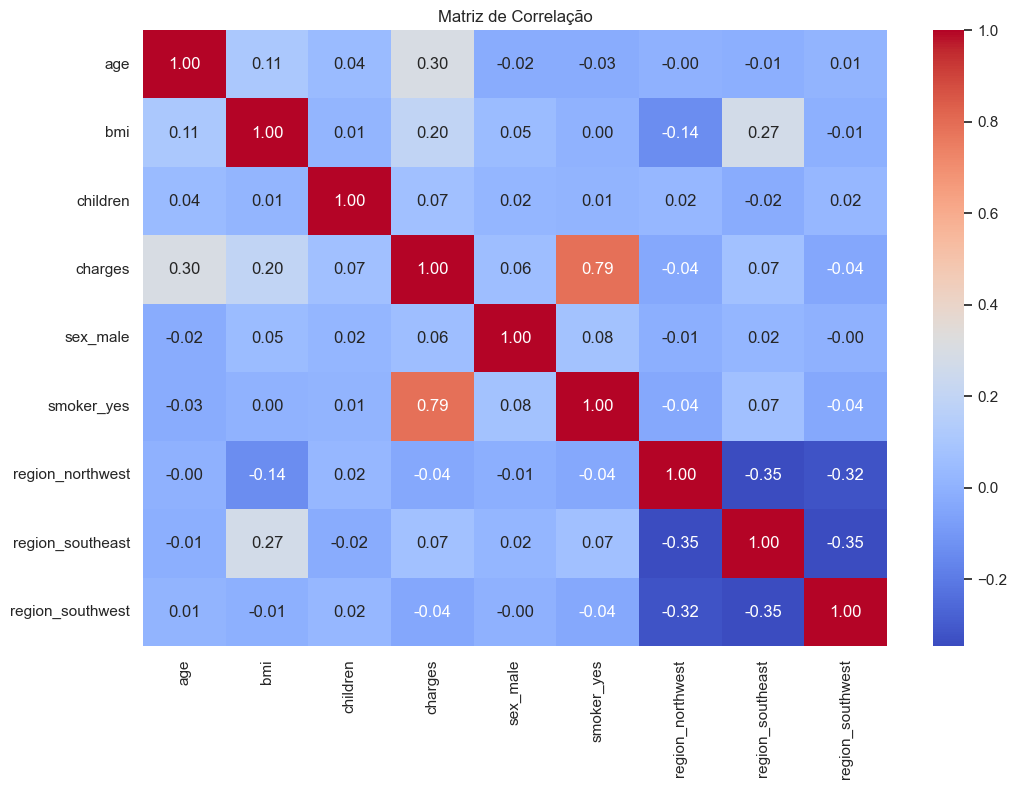

In [28]:
import matplotlib.pyplot as plt

# Calcular a mtriz de correlação
correlacao = dados_processados.corr()

# Plotar o heatmap da correlação
plt.figure(figsize=(12, 8))
sns.heatmap(correlacao, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Matriz de Correlação")
plt.show()  


## 5- Preparar os Dados para o Treino

In [29]:
# Separando as features (X) e o target (y)
X = dados_processados.drop(columns=["charges"], errors='ignore')  
y = dados_processados["charges"] 

# Divisão dos dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Conjunto de treinamento: {X_train.shape}")
print(f"Conjunto de teste: {X_test.shape}")

print(f"\nTipos do treinamento: \n{X_train.dtypes}")
print(f"\nTipos do teste: \n{X_test.dtypes}")

Conjunto de treinamento: (1070, 8)
Conjunto de teste: (268, 8)

Tipos do treinamento: 
age                   int64
bmi                 float64
children              int64
sex_male               bool
smoker_yes             bool
region_northwest       bool
region_southeast       bool
region_southwest       bool
dtype: object

Tipos do teste: 
age                   int64
bmi                 float64
children              int64
sex_male               bool
smoker_yes             bool
region_northwest       bool
region_southeast       bool
region_southwest       bool
dtype: object


## 6- Treinar o Modelo de Regressão

In [33]:
# Inicilizar o modelo de regressão
modelos = {

    # -- Base line --
    "Regressao Linear": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=100, random_state=42),
    "CatBoost": CatBoostRegressor(iterations=100, random_state=42, verbose=0), 

    # -- Modelos Tunados V0 --
    "Random Forest Tunado V0": RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42),
    "Gradient Boosting Tunado V0": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42),
    "XGBoost Tunado V0": XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42),
    "LightGBM Tunado V0": LGBMRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42),
    "CatBoost Tunado V0": CatBoostRegressor(iterations=200, learning_rate=0.1, depth=5, random_state=42, verbose=0),

    # -- Modelos Tunados V1 --
    "Random Forest Tunado V1": RandomForestRegressor(n_estimators=300, max_depth=15, min_samples_split=5, random_state=42),
    "Gradient Boosting Tunado V1": GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=7, min_samples_split=5, random_state=42),
    "XGBoost Tunado V1": XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=7, min_child_weight=3, random_state=42),
    "LightGBM Tunado V1": LGBMRegressor(n_estimators=300, learning_rate=0.05, max_depth=7, min_child_samples=20, random_state=42),
    "CatBoost Tunado V1": CatBoostRegressor(iterations=300, learning_rate=0.05, depth=7, random_state=42, verbose=0),
}

resultados = []

# Avaliar cada modelo
for nome, modelo in modelos.items():
    inicio = time.time()
    modelo.fit(X_train, y_train)  # Treinamento
    fim = time.time()

    # Previsões
    y_pred = modelo.predict(X_test)

    # Métricas
    mse = mean_squared_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    tempo_treino = fim - inicio

    # Registrar no MLflow
    with mlflow.start_run(run_name=nome):
        mlflow.log_param("Modelo", nome)
        mlflow.log_metric("Mean Squared Error-MSE", mse)
        mlflow.log_metric("Root Mean Squared Error-RMSE", rmse)
        mlflow.log_metric("Mean Absolute Error-MAE", mae)
        mlflow.log_metric("R-squared-R2", r2)
        mlflow.log_metric("Tempo de Treinamento", tempo_treino)
        mlflow.sklearn.log_model(modelo, "modelo")

    # Armazenar resultados
    resultados.append({
        "Modelo": nome,
        "Mean Squared Error (MSE)": mse,
        "Root Mean Squared Error (RMSE)": rmse,
        "Mean Absolute Error (MAE)": mae,
        "R-squared (R²)": r2,
        "Tempo de Treinamento (s)": tempo_treino
    })
    print(f"Modelo {nome} treinado e registrado no MLflow.")

2025/11/02 17:13:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Regressao Linear at: https://dagshub.com/ahmiura/modelagem-exe1-regressao.mlflow/#/experiments/0/runs/b334aabf895a41af8f72d5e01059d1c9
🧪 View experiment at: https://dagshub.com/ahmiura/modelagem-exe1-regressao.mlflow/#/experiments/0
Modelo Regressao Linear treinado e registrado no MLflow.


2025/11/02 17:13:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Random Forest at: https://dagshub.com/ahmiura/modelagem-exe1-regressao.mlflow/#/experiments/0/runs/387a8ae69cb84d1bb083bee2a74f577b
🧪 View experiment at: https://dagshub.com/ahmiura/modelagem-exe1-regressao.mlflow/#/experiments/0
Modelo Random Forest treinado e registrado no MLflow.


2025/11/02 17:13:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Gradient Boosting at: https://dagshub.com/ahmiura/modelagem-exe1-regressao.mlflow/#/experiments/0/runs/6f4b6a2ba6ae43f9a5d821426f025705
🧪 View experiment at: https://dagshub.com/ahmiura/modelagem-exe1-regressao.mlflow/#/experiments/0
Modelo Gradient Boosting treinado e registrado no MLflow.


2025/11/02 17:14:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost at: https://dagshub.com/ahmiura/modelagem-exe1-regressao.mlflow/#/experiments/0/runs/55dcf966234441488d8554156b5d8b53
🧪 View experiment at: https://dagshub.com/ahmiura/modelagem-exe1-regressao.mlflow/#/experiments/0
Modelo XGBoost treinado e registrado no MLflow.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 1070, number of used features: 8
[LightGBM] [Info] Start training from score 13346.089733


2025/11/02 17:14:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LightGBM at: https://dagshub.com/ahmiura/modelagem-exe1-regressao.mlflow/#/experiments/0/runs/c7476b1a02eb4c6ea96a800fc13289ca
🧪 View experiment at: https://dagshub.com/ahmiura/modelagem-exe1-regressao.mlflow/#/experiments/0
Modelo LightGBM treinado e registrado no MLflow.


2025/11/02 17:14:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run CatBoost at: https://dagshub.com/ahmiura/modelagem-exe1-regressao.mlflow/#/experiments/0/runs/466c5fd9d7ab43f6a06af2ef119dc434
🧪 View experiment at: https://dagshub.com/ahmiura/modelagem-exe1-regressao.mlflow/#/experiments/0
Modelo CatBoost treinado e registrado no MLflow.


2025/11/02 17:15:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Random Forest Tunado V0 at: https://dagshub.com/ahmiura/modelagem-exe1-regressao.mlflow/#/experiments/0/runs/c68943855db74dd7a3d476bfd58b5324
🧪 View experiment at: https://dagshub.com/ahmiura/modelagem-exe1-regressao.mlflow/#/experiments/0
Modelo Random Forest Tunado V0 treinado e registrado no MLflow.


2025/11/02 17:15:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Gradient Boosting Tunado V0 at: https://dagshub.com/ahmiura/modelagem-exe1-regressao.mlflow/#/experiments/0/runs/e9ce7fe32cb547aca797dbdf79a5d227
🧪 View experiment at: https://dagshub.com/ahmiura/modelagem-exe1-regressao.mlflow/#/experiments/0
Modelo Gradient Boosting Tunado V0 treinado e registrado no MLflow.


2025/11/02 17:15:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost Tunado V0 at: https://dagshub.com/ahmiura/modelagem-exe1-regressao.mlflow/#/experiments/0/runs/8539d38918f7485a9ebff63efbc1fa73
🧪 View experiment at: https://dagshub.com/ahmiura/modelagem-exe1-regressao.mlflow/#/experiments/0
Modelo XGBoost Tunado V0 treinado e registrado no MLflow.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 1070, number of used features: 8
[LightGBM] [Info] Start training from score 13346.089733
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

2025/11/02 17:15:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LightGBM Tunado V0 at: https://dagshub.com/ahmiura/modelagem-exe1-regressao.mlflow/#/experiments/0/runs/04d375a279274990b8c61663ac9f18e0
🧪 View experiment at: https://dagshub.com/ahmiura/modelagem-exe1-regressao.mlflow/#/experiments/0
Modelo LightGBM Tunado V0 treinado e registrado no MLflow.


2025/11/02 17:16:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run CatBoost Tunado V0 at: https://dagshub.com/ahmiura/modelagem-exe1-regressao.mlflow/#/experiments/0/runs/bca77eba12b44a51b1b3386764bea4f2
🧪 View experiment at: https://dagshub.com/ahmiura/modelagem-exe1-regressao.mlflow/#/experiments/0
Modelo CatBoost Tunado V0 treinado e registrado no MLflow.


2025/11/02 17:16:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Random Forest Tunado V1 at: https://dagshub.com/ahmiura/modelagem-exe1-regressao.mlflow/#/experiments/0/runs/42b42eb853d341dfb7b85f215df9945c
🧪 View experiment at: https://dagshub.com/ahmiura/modelagem-exe1-regressao.mlflow/#/experiments/0
Modelo Random Forest Tunado V1 treinado e registrado no MLflow.


2025/11/02 17:16:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Gradient Boosting Tunado V1 at: https://dagshub.com/ahmiura/modelagem-exe1-regressao.mlflow/#/experiments/0/runs/55be8b5958d44fb7bfe9814a0e33fabf
🧪 View experiment at: https://dagshub.com/ahmiura/modelagem-exe1-regressao.mlflow/#/experiments/0
Modelo Gradient Boosting Tunado V1 treinado e registrado no MLflow.


2025/11/02 17:16:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost Tunado V1 at: https://dagshub.com/ahmiura/modelagem-exe1-regressao.mlflow/#/experiments/0/runs/e9e3feb2b12941648d182dcb57aa4c57
🧪 View experiment at: https://dagshub.com/ahmiura/modelagem-exe1-regressao.mlflow/#/experiments/0
Modelo XGBoost Tunado V1 treinado e registrado no MLflow.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 1070, number of used features: 8
[LightGBM] [Info] Start training from score 13346.089733
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

2025/11/02 17:17:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LightGBM Tunado V1 at: https://dagshub.com/ahmiura/modelagem-exe1-regressao.mlflow/#/experiments/0/runs/06d9dce94df146be9d01423072062c5d
🧪 View experiment at: https://dagshub.com/ahmiura/modelagem-exe1-regressao.mlflow/#/experiments/0
Modelo LightGBM Tunado V1 treinado e registrado no MLflow.


2025/11/02 17:17:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run CatBoost Tunado V1 at: https://dagshub.com/ahmiura/modelagem-exe1-regressao.mlflow/#/experiments/0/runs/3748f7c905a8491db22d0622f01512dd
🧪 View experiment at: https://dagshub.com/ahmiura/modelagem-exe1-regressao.mlflow/#/experiments/0
Modelo CatBoost Tunado V1 treinado e registrado no MLflow.


## 5- Resultados da Comparação

In [34]:
# Criar um DataFrame com os resultados
df_resultados = pd.DataFrame(resultados)
df_resultados.sort_values(
    by=["R-squared (R²)", "Mean Absolute Error (MAE)", "Tempo de Treinamento (s)"],
    ascending=[False, True, True],
    inplace=True
)
print("Resultados da Comparação:")
print(df_resultados)

# Exibir o modelo com melhor desempenho
melhor_modelo = df_resultados.iloc[0]
print(f"Melhor Modelo: {melhor_modelo['Modelo']}")

Resultados da Comparação:
                         Modelo  Mean Squared Error (MSE)  \
10           CatBoost Tunado V0              1.839965e+07   
2             Gradient Boosting              1.874518e+07   
9            LightGBM Tunado V0              1.960897e+07   
15           CatBoost Tunado V1              1.970313e+07   
11      Random Forest Tunado V1              2.033097e+07   
4                      LightGBM              2.055738e+07   
6       Random Forest Tunado V0              2.069437e+07   
14           LightGBM Tunado V1              2.084701e+07   
8             XGBoost Tunado V0              2.093517e+07   
1                 Random Forest              2.094252e+07   
13            XGBoost Tunado V1              2.133452e+07   
5                      CatBoost              2.221292e+07   
3                       XGBoost              2.343470e+07   
7   Gradient Boosting Tunado V0              2.597209e+07   
12  Gradient Boosting Tunado V1              2.738226e+07  

## 6- Armazenando o Melhor Modelo no MLflow

In [35]:
# Recuperar o modelo com melhor desempenho
nome_melhor_modelo = melhor_modelo["Modelo"]
modelo_final = modelos[nome_melhor_modelo]

# Armazenar o modelo final no MLflow
with mlflow.start_run(run_name="Melhor Modelo"):
    mlflow.log_param("Modelo", nome_melhor_modelo)
    mlflow.log_metric("Mean Squared Error-MSE", mse)
    mlflow.log_metric("Root Mean Squared Error-RMSE", rmse)
    mlflow.log_metric("Mean Absolute Error-MAE", mae)
    mlflow.log_metric("R-squared-R2", r2)
    mlflow.log_metric("Tempo de Treinamento", melhor_modelo["Tempo de Treinamento (s)"])
    mlflow.sklearn.log_model(modelo_final, "melhor_modelo")
print(f"Melhor modelo ({nome_melhor_modelo}) armazenado com sucesso no MLflow.")

2025/11/02 17:21:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Melhor Modelo at: https://dagshub.com/ahmiura/modelagem-exe1-regressao.mlflow/#/experiments/0/runs/4263b1c39b4f4e8a93d41a1ef3124ea2
🧪 View experiment at: https://dagshub.com/ahmiura/modelagem-exe1-regressao.mlflow/#/experiments/0
Melhor modelo (CatBoost Tunado V0) armazenado com sucesso no MLflow.


## 7- Exercícios


1.   Verificar a documentação dos modelos RandomForestClassifier, LogisticRegression, KNeighborsClassifier, GradientBoostingClassifier e altere ou inclua algum parâmetro dos modelos e compare os resultados com o baseline executado nesse notebook.
2.   Busque algum outro dataset no Kaggle para um problema de regressão e faça um novo treino. Lembre de modificar as métricas, ex.: MSE.
3.   Execute o MLFlow de maneira que se parar o container os dados não sejam perdidos, podendo salvar os dados ou no SQLite (default) ou outro banco de dados da sua escolha.

**Importante:**

*   Todas as alterações devem ser registradas no Mlflow (subir em container) para que seja possível realizar comparações entre os experimentos.

## Conclusão


Este notebook demonstrou como comparar múltiplos algoritmos de machine learning, avaliar seus desempenhos e armazenar o melhor modelo no MLflow.
O MLflow foi utilizado para rastrear e versionar os experimentos e os modelos de forma eficaz.
    